In [8]:
!pip install -r requirements.txt --quiet


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [9]:
%matplotlib inline
import pymc as pm
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import arviz as az
import networkx as nx
import collections.abc
collections.Iterable = collections.abc.Iterable
from causalgraphicalmodels import CausalGraphicalModel
from sklearn.preprocessing import StandardScaler
scale = StandardScaler()

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

plt.style.use(['seaborn-v0_8-darkgrid','seaborn-v0_8-colorblind'])

#### Code 6.1

In [10]:
np.random.seed(1914)
N = 200
p = .1
# uncorrelated newsworthiness and trustworthiness
nw = np.random.normal(0, 1, N)
tw = np.random.normal( 0, 1,N)
s = nw + tw # total score
q = np.quantile(s,  1-p) # thop 10% threshold
selected = np.where(s >= q, True, False)
corr = np.corrcoef(tw[selected], nw[selected])
corr

array([[ 1.        , -0.64839295],
       [-0.64839295,  1.        ]])

#### Code 6.2

In [11]:
N = 100
np.random.seed(909)
height = np.random.normal(10,2,N)
leg_prop = np.random.uniform(.4,.5,N)
leg_left = leg_prop * height + np.random.normal(0,.2,N)
leg_right = leg_prop * height + np.random.normal(0,.2,N)
d = pd.DataFrame({'height':height,'leg_left': leg_left, 'leg_right': leg_right})
d

,height,leg_left,leg_right
0,8.463728,4.230768,4.068480
1,9.854070,5.239473,4.352217
2,8.668694,4.040752,4.679396
3,7.523768,2.956471,2.951798
4,9.381352,4.359430,3.909069
...,...,...,...
95,12.610697,5.516146,5.571880
96,8.752141,4.293982,4.295304
97,8.923187,3.802976,3.622485
98,8.424561,4.117680,3.835224


#### Code 6.3

In [12]:
with pm.Model() as m6_1:
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 10, 100)
    bl = pm.Normal('bl',2,10)
    br = pm.Normal('br',2,10)
    mu = pm.Deterministic('mu', a + bl * d.leg_left + br * d.leg_right)
    height = pm.Normal('height', mu = mu, sigma = sigma, observed = d.height)
    trace_m6_1 = pm.sample(cores =1, chains = 4)

pm.summary(trace_m6_1, var_names= ['a', 'bl','br','sigma'])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, bl, br]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.112,0.371,0.410,1.795,0.008,0.005,2404.0,2238.0,1.0
bl,0.678,0.260,0.194,1.151,0.006,0.004,1740.0,1684.0,1.0
br,1.281,0.243,0.844,1.749,0.006,0.004,1844.0,1909.0,1.0
sigma,0.738,0.055,0.633,0.837,0.001,0.001,2162.0,2194.0,1.0


#### Code 6.4

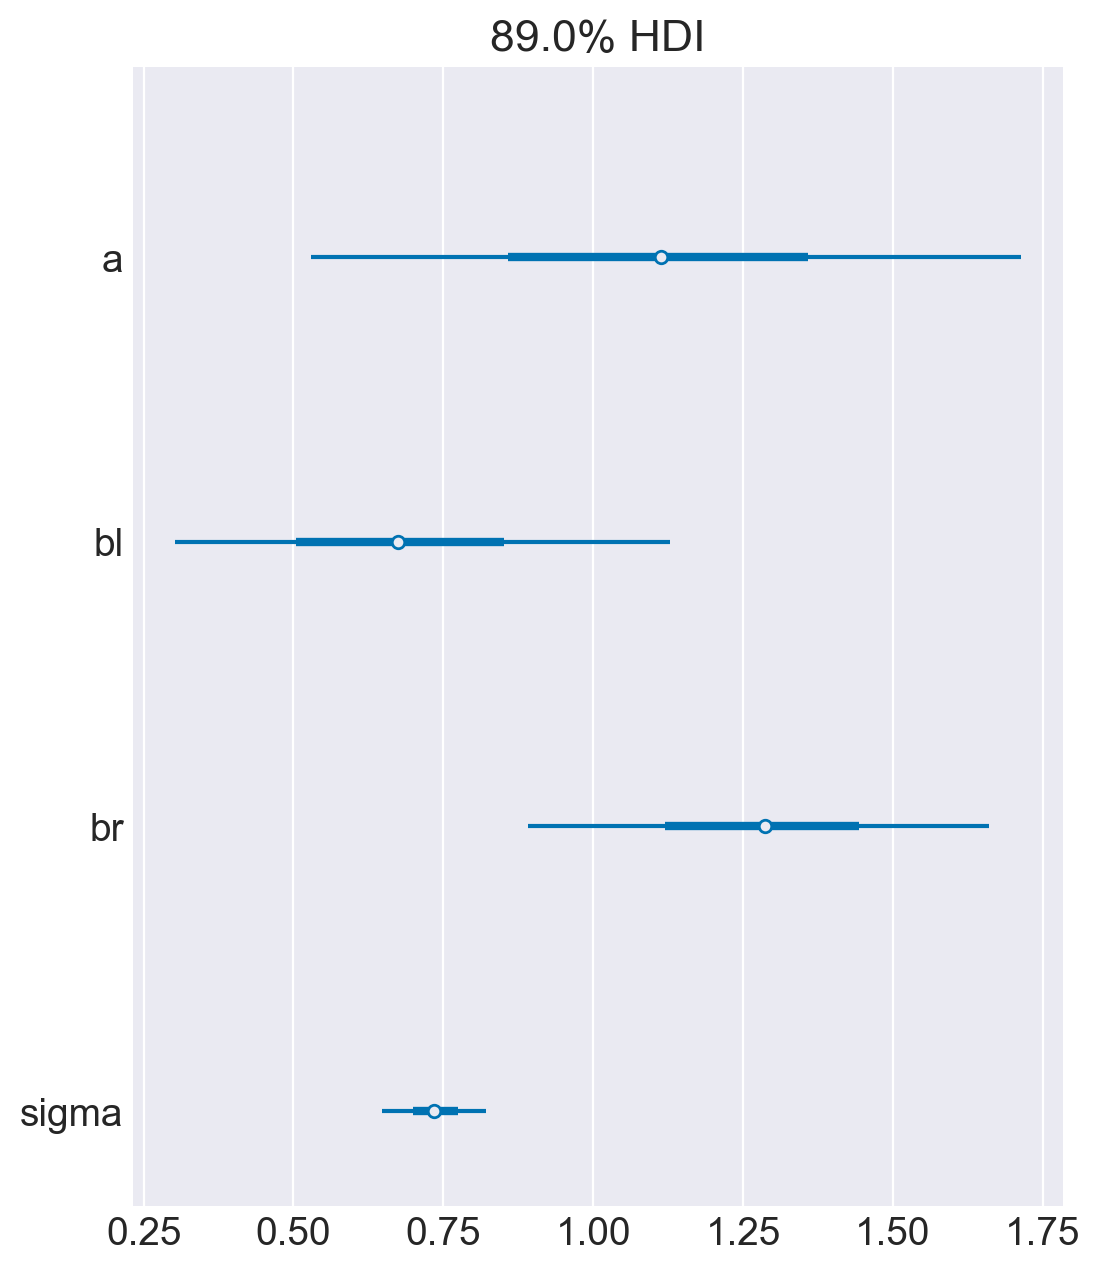

In [13]:
az.plot_forest(trace_m6_1, 
var_names = ['a','bl','br','sigma'], 
combined = True,
hdi_prob = .89);

#### Code 6.5

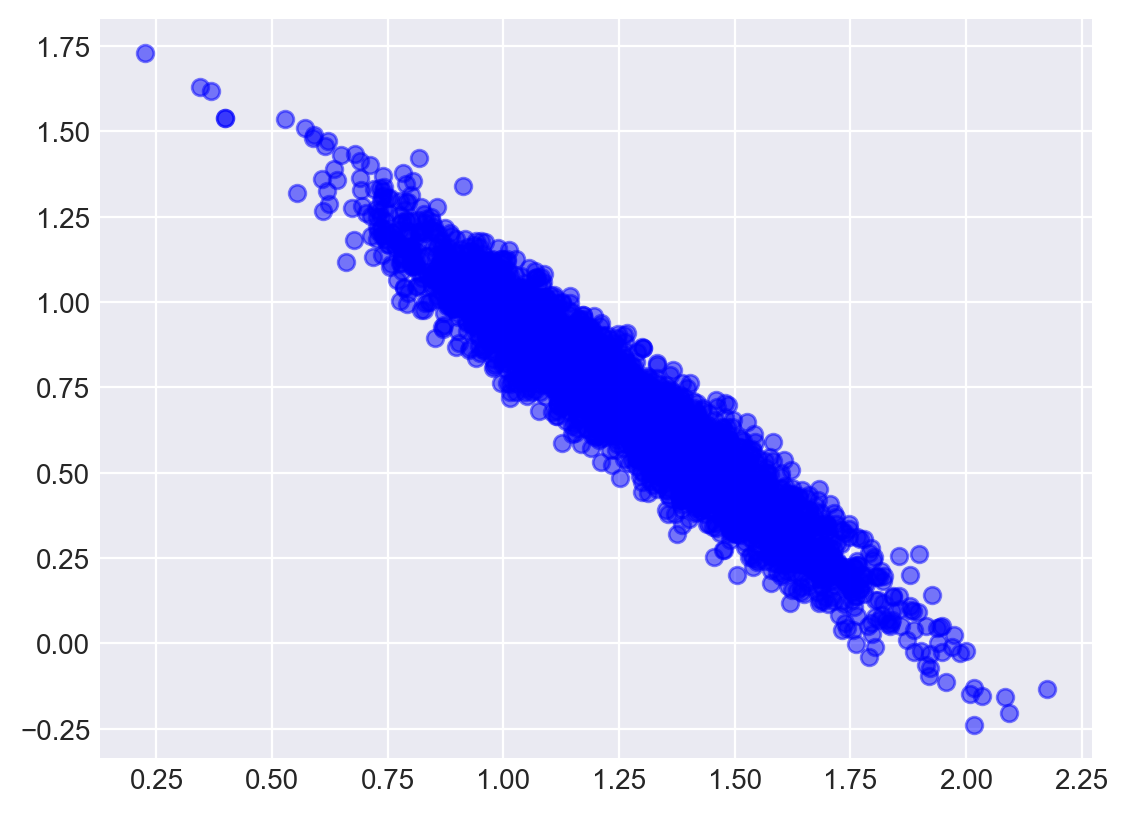

In [14]:
with m6_1:
    post = trace_m6_1.posterior.to_dataframe().reset_index().drop_duplicates(subset=['chain','draw'])
plt.scatter(post.br,post.bl,alpha=.5,color='blue')


##### Code 6.6

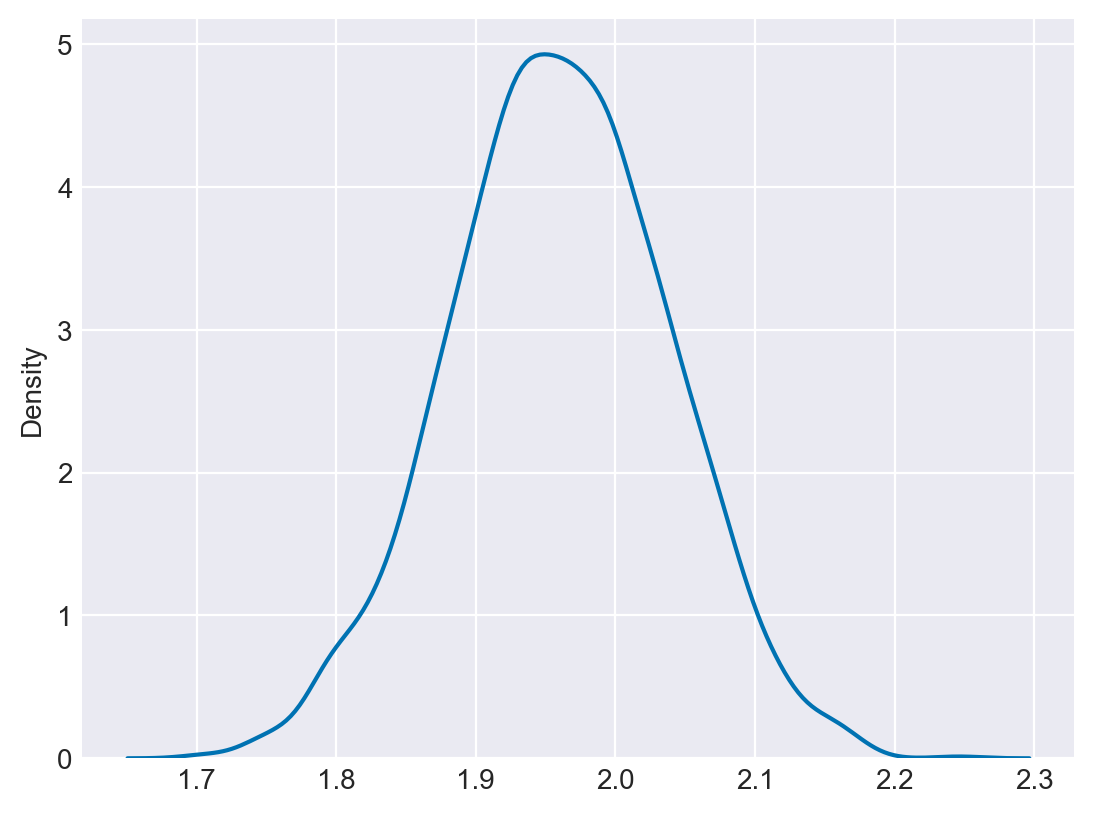

In [15]:
sns.kdeplot(post.br+post.bl);

#### Code 6.7

In [16]:
with pm.Model() as m6_2:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', 10,100)
    bl = pm.Normal('bl', 2,10)
    mu = pm.Deterministic('mu', a + bl * d.leg_left)
    height = pm.Normal('height', mu = mu, sigma = sigma, observed = d.height)
    trace_m6_2 = pm.sample(cores = 1, chains = 4)

pm.summary(trace_m6_2, var_names = ['a', 'bl', 'sigma'])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, bl]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.937,0.404,0.196,1.722,0.011,0.008,1454.0,1676.0,1.0
bl,1.994,0.086,1.836,2.159,0.002,0.002,1447.0,1760.0,1.0
sigma,0.839,0.060,0.733,0.956,0.001,0.001,2165.0,1596.0,1.0


#### Code 6.8

In [17]:
d = pd.read_csv('data/milk.csv', sep=';')
d['K'] = scale.fit_transform(d[['kcal.per.g']])
d['F'] = scale.fit_transform(d[['perc.fat']])
d['L'] = scale.fit_transform(np.log(d[['perc.lactose']]))

#### Code 6.9

In [18]:
with pm.Model() as m6_3:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', 0,.2)
    bF = pm.Normal('bF', 0,.5)
    mu = pm.Deterministic('mu', a + bF * d.F)
    K = pm.Normal('K', mu = mu, sigma = sigma, observed = d.K)
    trace_m6_3 = pm.sample(cores = 1, chains = 4)

with pm.Model() as m6_4:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', 10,100)
    bL = pm.Normal('bL', 0,.5)
    mu = pm.Deterministic('mu', a + bL * d.L)
    K = pm.Normal('K', mu = mu, sigma = sigma, observed = d.K)
    trace_m6_4 = pm.sample(cores = 1, chains = 4)

display(pm.summary(trace_m6_3, var_names = ['a','bF','sigma']))
display(pm.summary(trace_m6_4, var_names = ['a','bL','sigma']))

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, bF]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, bL]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.000,0.086,-0.159,0.163,0.001,0.001,4282.0,2774.0,1.0
bF,0.857,0.090,0.676,1.016,0.001,0.001,4304.0,2682.0,1.0
sigma,0.497,0.072,0.374,0.629,0.001,0.001,4230.0,2751.0,1.0


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.065,-0.115,0.131,0.001,0.001,5466.0,2930.0,1.0
bL,-0.930,0.065,-1.050,-0.800,0.001,0.001,3570.0,2564.0,1.0
sigma,0.349,0.050,0.265,0.447,0.001,0.001,3735.0,2540.0,1.0


#### Code 6.10

In [19]:
with pm.Model() as m6_5:
    sigma = pm.Exponential('sigma',1)
    a = pm.Normal('a', 10,100)
    bL = pm.Normal('bL', 0,.5)
    bF = pm.Normal('bF', 0,.5)
    mu = pm.Deterministic('mu', a + bL * d.L + bF * d.F)
    K = pm.Normal('K', mu = mu, sigma = sigma, observed = d.K)
    trace_m6_5 = pm.sample(cores = 1, chains = 4)

display(pm.summary(trace_m6_5, var_names = ['a','bL','bF','sigma']))

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, bL, bF]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.001,0.065,-0.118,0.125,0.001,0.001,2692.0,2283.0,1.0
bL,-0.813,0.168,-1.123,-0.484,0.004,0.003,1510.0,1624.0,1.0
bF,0.128,0.166,-0.191,0.442,0.004,0.003,1543.0,1870.0,1.0
sigma,0.355,0.053,0.264,0.455,0.001,0.001,2442.0,2002.0,1.0


#### Code 6.11

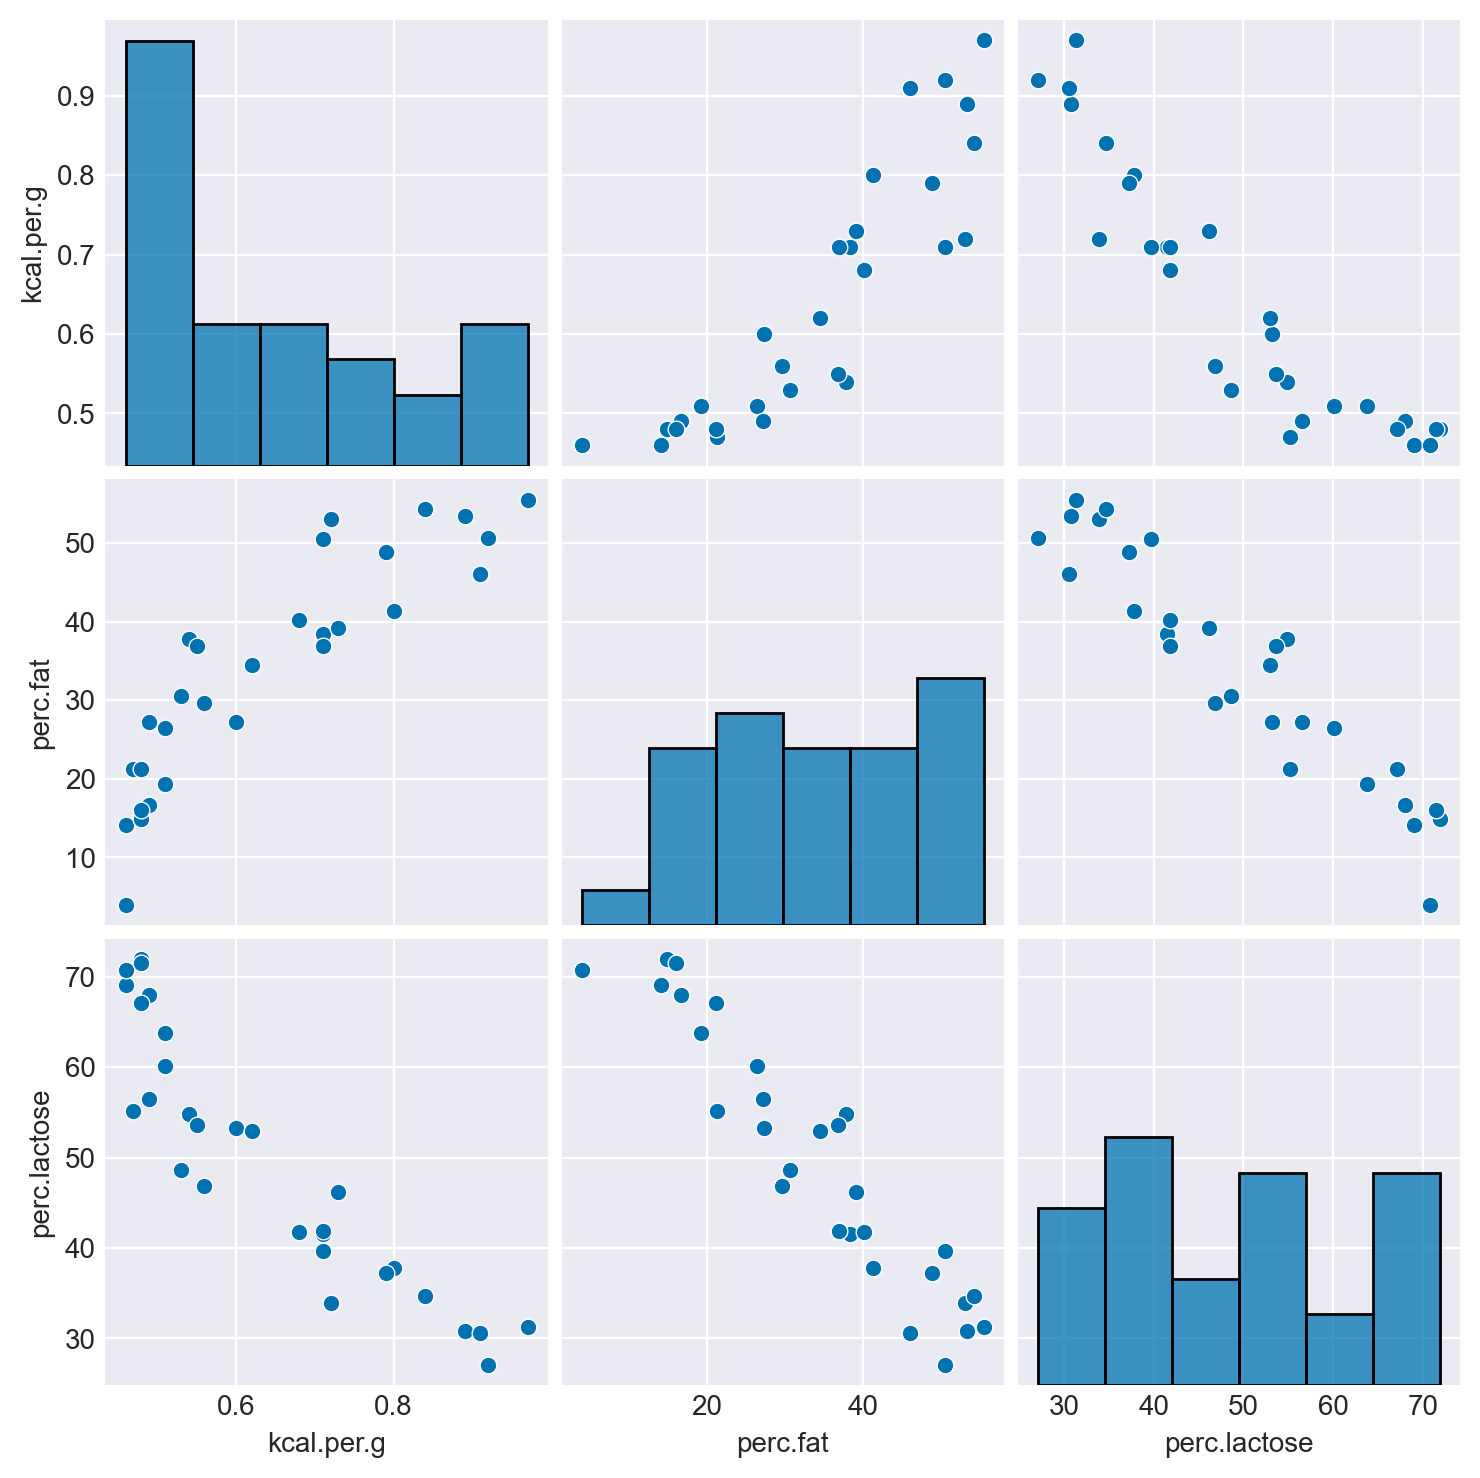

In [20]:
with m6_5:
    post = trace_m6_5.posterior.to_dataframe().reset_index().drop_duplicates(subset=['chain','draw'])

sns.pairplot(d[['kcal.per.g', 'perc.fat', 'perc.lactose']]);


#### Code 6.12

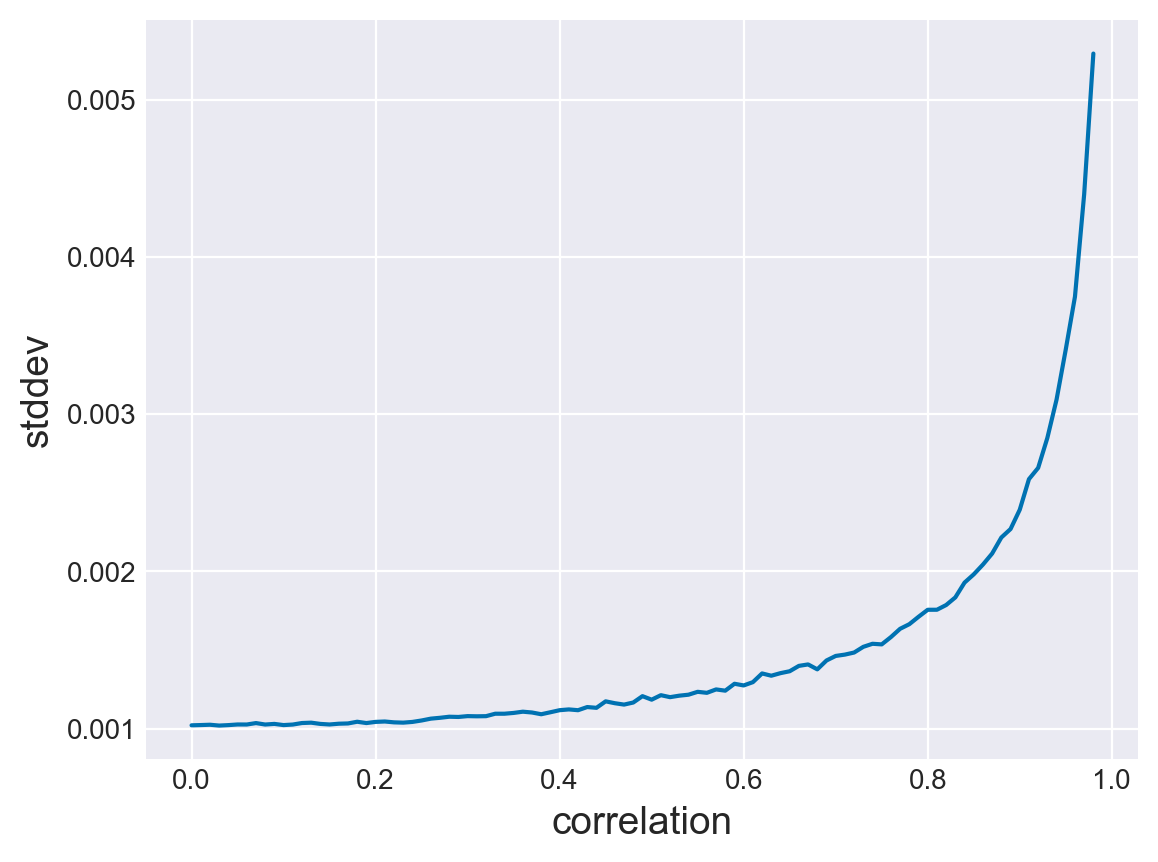

In [21]:
d = pd.read_csv('data/milk.csv', sep=';')
def simcoll(r = 0.9):
    d['x'] = stats.norm.rvs(size=len(d), loc = r * d['perc.fat'],
                       scale = np.sqrt((1 - r**2) * d['perc.fat'].var()))
    x = np.column_stack((d['perc.fat'], d['x']))
    m = smf.ols('d["kcal.per.g"] ~ d["perc.fat"] + d["x"]', data=d).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def repsimcoll(r= 0.9, N = 100):
    stddev = [simcoll(r) for _ in range(N)]
    return np.mean(stddev)

lista = []
for i in np.arange(start = 0, stop = 0.99, step = 0.01):   
    lista.append(repsimcoll (r= i, N = 100))

plt.plot(np.arange(start = 0, stop = 0.99, step = 0.01), lista)
plt.xlabel('correlation', fontsize=14)
plt.ylabel('stddev', fontsize=14);

#### Code 6.13

In [22]:
np.random.seed(71)
N = 100

h0 = np.random.normal(10,2,N)

treatment = np.random.choice([0, 1], size=N, replace=True)
fungus = np.random.binomial(1,.5 - treatment*.4, N)
h1 = h0 + np.random.normal(5-3 * fungus, 1, N)

d = pd.DataFrame({'h0':h0, 
                  'h1':h1, 
                  'treatment':treatment,
                  'fungus': fungus})

d.describe()

,h0,h1,treatment,fungus
count,100.000000,100.000000,100.000000,100.000000
mean,10.151728,14.528096,0.580000,0.270000
std,1.667146,2.423305,0.496045,0.446196
min,6.087715,6.867038,0.000000,0.000000
25%,9.045405,13.076415,0.000000,0.000000
50%,10.117129,14.515677,1.000000,0.000000
75%,11.368423,16.050646,1.000000,1.000000
max,13.885944,19.757884,1.000000,1.000000


#### Code 6.14

In [23]:
sim_p = pd.DataFrame(np.random.lognormal(0,.24, 10000))
sim_p.describe()

,0
count,10000.000000
mean,1.030200
std,0.251167
min,0.407056
25%,0.850465
50%,1.000413
75%,1.174440
max,2.715438


#### Code 6.15

In [24]:
with pm.Model() as m6_6:
    sigma = pm.Exponential('sigma', 1)
    p = pm.LogNormal('p', 0, .25)
    mu = pm.Deterministic('mu', d.h0.values * p)
    h1 = pm.Normal('h1', mu = mu, sigma = sigma, observed = d.h1.values)
    trace_m6_7 = pm.sample(cores = 1)
pm.summary(trace_m6_7, var_names = ['p','sigma'])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, p]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p,1.417,0.018,1.382,1.451,0.000,0.000,1899.0,1396.0,1.0
sigma,1.969,0.144,1.716,2.240,0.003,0.002,1915.0,1259.0,1.0


#### Code 6.16

In [25]:
with pm.Model() as m6_7:
    sigma = pm.Exponential('sigma', 1)
    a = pm.LogNormal('a', 0, .2)
    bt = pm.Normal('bt', 0, .5)
    bf = pm.Normal('bf', 0, .5)
    p = pm.Deterministic('p',a + bt * d.treatment.values + bf * d.fungus.values)
    mu = pm.Deterministic('mu', d.h0.values * p)
    h1 = pm.Normal('h1', mu = mu, sigma = sigma, observed = d.h1.values)
    trace_m6_6 = pm.sample(cores = 1)
    
pm.summary(trace_m6_6, var_names = ['a', 'bt','bf','sigma'])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bt, bf]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.506,0.024,1.460,1.548,0.001,0.000,1216.0,1319.0,1.0
bt,0.001,0.027,-0.047,0.051,0.001,0.001,1218.0,1267.0,1.0
bf,-0.329,0.029,-0.377,-0.266,0.001,0.001,1230.0,1271.0,1.0
sigma,1.262,0.092,1.093,1.426,0.002,0.002,1711.0,1427.0,1.0


#### Code 6.17

In [26]:
with pm.Model() as m6_8:
    sigma = pm.Exponential('sigma', 1)
    a = pm.LogNormal('a', 0, .2)
    bt = pm.Normal('bt', 0, .5)
    p = pm.Deterministic('p',a + bt * d.treatment.values)
    mu = pm.Deterministic('mu', d.h0.values * p)
    h1 = pm.Normal('h1', mu = mu, sigma = sigma, observed = d.h1.values)
    trace_m6_8 = pm.sample(cores = 1)
    
pm.summary(trace_m6_8, var_names = ['a', 'bt','sigma'])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bt]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.359,0.029,1.305,1.411,0.001,0.001,1094.0,1032.0,1.0
bt,0.098,0.038,0.025,0.166,0.001,0.001,1104.0,1201.0,1.0
sigma,1.918,0.139,1.642,2.165,0.004,0.003,1356.0,956.0,1.0


#### Code 6.18

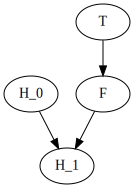

In [27]:
model = CausalGraphicalModel(
    nodes = ['H_0', 'H_1', 'F', 'T'],
    edges = [('H_0','H_1'),('F','H_1'),('T','F')]
)
display(model.draw())


#### Code 6.19

In [28]:
model.get_all_independence_relationships()


[('H_0', 'F', set()),
 ('H_0', 'F', {'T'}),
 ('H_0', 'T', set()),
 ('H_0', 'T', {'F'}),
 ('H_0', 'T', {'F', 'H_1'}),
 ('H_1', 'T', {'F'}),
 ('H_1', 'T', {'F', 'H_0'})]

#### Code 6.20

In [29]:
N = 1000
h0 = np.random.normal(10,2,N)
M = np.random.binomial(1,0.5, N)
treatment = np.random.choice([0, 1], size=N, replace=True)
fungus = np.random.binomial(1,.5 - treatment*.4 + .4 * M, N)
h1 = h0 + np.random.normal(5-3 * M, 1, N)
d = pd.DataFrame({'h0':h0, 
                  'h1':h1, 
                  'treatment':treatment,
                  'fungus': fungus})

d.describe()



,h0,h1,treatment,fungus
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,10.103262,13.599249,0.496000,0.506000
std,2.007453,2.621347,0.500234,0.500214
min,3.691893,6.414127,0.000000,0.000000
25%,8.751484,11.778821,0.000000,0.000000
50%,10.117410,13.582428,0.000000,1.000000
75%,11.473137,15.400653,1.000000,1.000000
max,17.410448,21.929540,1.000000,1.000000


#### Code 6.21

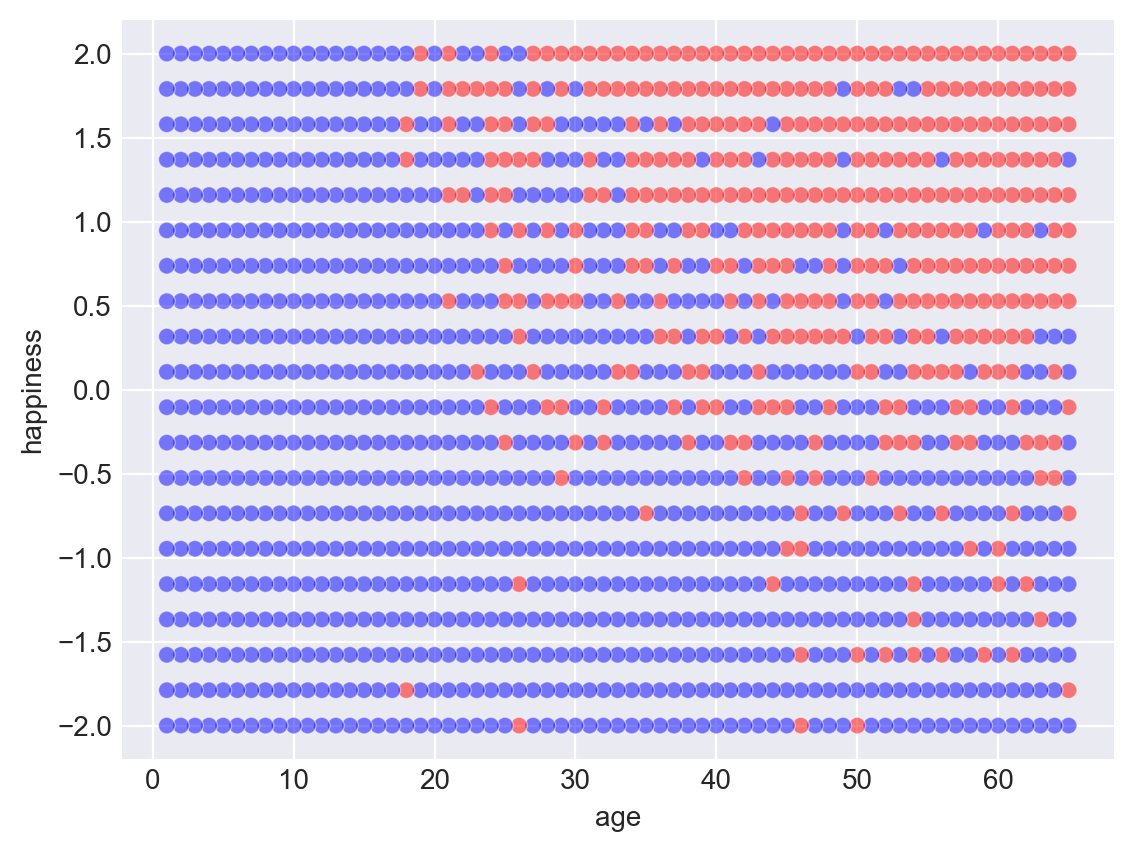

In [30]:
def sim_happiness(seed=1977, N_years=1000, max_age=65, N_births=20, aom=18):
    np.random.seed(seed)

    H, M, A = [], [], []

    for t in range(N_years):
        A = [age + 1 for age in A]
        A.extend([1] * N_births)

        H.extend(np.linspace(-2, 2, N_births))

        M.extend([0] * N_births)

        for i in range(len(A)):
            if A[i] >= aom and M[i] == 0:
                M[i] = np.random.binomial(1, 1 / (1 + np.exp(-(H[i] - 4))))

        deaths = [i for i, age in enumerate(A) if age > max_age]
        for i in sorted(deaths, reverse=True):
            del A[i]
            del H[i]
            del M[i]

    d = pd.DataFrame({'age': A, 'married': M, 'happiness': H})
    return d

d= sim_happiness()

sns.scatterplot(x='age', y='happiness', data=d, alpha=.5, hue='married', palette=['blue','red'], legend=False);

In [31]:
d2 = d[d['age'] > 17]
d2['A'] = (d2.age.values- 18) / (65 - 18)

#### Code 6.23

,age,married,happiness,A
0,65,0,-2.000000,1
1,65,1,-1.789474,1
2,65,0,-1.578947,1
3,65,0,-1.368421,1
4,65,0,-1.157895,1


In [42]:
with pm.Model() as m6_9: 
    sigma= pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0,1, shape = 2)
    bA = pm.Normal('bA', 0, 2)
    mu = pm.Deterministic('mu', a[d2.married.values] + bA * d2.A.values)
    happiness = pm.Normal('happiness', mu = mu, sigma = sigma, observed = d2.happiness.values)
    trace_m6_9 = pm.sample(300, cores = 1, chains = 4)
pm.summary(trace_m6_9, var_names = ['a','bA','sigma'])


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, bA]


Output()

Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],-0.550,0.042,-0.623,-0.469,0.001,0.001,1772.0,943.0,1.01
a[1],0.849,0.050,0.756,0.936,0.001,0.001,1765.0,1123.0,1.00
bA,-0.147,0.220,-0.548,0.254,0.005,0.005,2223.0,1014.0,1.00
sigma,1.004,0.022,0.960,1.044,0.001,0.000,1364.0,1003.0,1.00


#### Code 6.24

In [32]:
with pm.Model() as m6_9: 
    sigma= pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0,1)
    bA = pm.Normal('bA', 0, 2)
    mu = pm.Deterministic('mu', a+ bA * d2.A.values)
    happiness = pm.Normal('happiness', mu = mu, sigma = sigma, observed = d2.happiness.values)
    trace_m6_9 = pm.sample(300, cores = 1, chains = 4)
pm.summary(trace_m6_9, var_names = ['a','bA','sigma'])

Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, bA]


Output()

Sampling 4 chains for 1_000 tune and 300 draw iterations (4_000 + 1_200 draws total) took 3 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.006,0.074,-0.143,0.131,0.003,0.002,636.0,678.0,1.00
bA,0.008,0.131,-0.249,0.250,0.005,0.004,584.0,672.0,1.00
sigma,1.217,0.029,1.164,1.271,0.001,0.001,709.0,613.0,1.01


#### Code 6.25

In [62]:
N = 2000
b_GP = 1
b_GC = 0
b_PC = 1
b_U = 2

#### Code 6.26

In [63]:
np.random.seed(1)
U = 2 * np.random.binomial(1, p=.5, size=N) - 1
G = np.random.normal(0,1,N)
P = np.random.normal(b_GP*G + b_U*U,1,N)
C = np.random.normal(b_PC*P + b_GC*G + b_U*U,1,N)
d = pd.DataFrame({'C':C, 'P':P, 'G':G, 'U':U})
d.sample(5)

,C,P,G,U
438,3.589113,1.863857,-0.448112,1
1720,4.515789,1.088878,0.167179,1
141,-5.025748,-3.173173,-1.116832,-1
353,-5.061997,-1.640892,0.941326,-1
535,1.627873,1.326825,-0.206761,1


### Code 6.27

In [64]:
with pm.Model() as m6_10: 
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0,1)
    b_PC = pm.Normal('b_PC', 0,1) 
    b_GC = pm.Normal('b_GC', 0,1) 
    mu = pm.Deterministic('mu', a + b_PC*d.P + b_GC*d.G) 
    C = pm.Normal('C', mu = mu, sigma = sigma, observed = d.C)
    trace_m6_10 = pm.sample(cores = 1, chains = 4)
pm.summary(trace_m6_10, var_names = ['a','b_PC','b_GC','sigma'])


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, b_PC, b_GC]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.052,0.031,-0.108,0.008,0.000,0.0,6637.0,3138.0,1.0
b_PC,1.797,0.014,1.771,1.821,0.000,0.0,3672.0,3107.0,1.0
b_GC,-0.731,0.034,-0.796,-0.670,0.001,0.0,3568.0,3336.0,1.0
sigma,1.349,0.021,1.310,1.389,0.000,0.0,5823.0,3435.0,1.0


#### Code 6.28


In [65]:
with pm.Model() as m6_11: 
    sigma = pm.Exponential('sigma', 1)
    a = pm.Normal('a', 0,1)
    b_GC = pm.Normal('b_GC', 0,1) 
    b_PC = pm.Normal('b_PC', 0,1)
    b_U = pm.Normal('b_U', 0,1) 
    mu  = pm.Deterministic('mu', a + b_GC*d.G + b_PC*d.P + b_U*d.U) 
    C = pm.Normal('C', mu = mu, sigma = sigma, observed = d.C)
    trace_m6_11 = pm.sample(cores = 1, chains = 4)
pm.summary(trace_m6_11, var_names = ['a','b_GC','b_PC','b_U','sigma'])


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
NUTS: [sigma, a, b_GC, b_PC, b_U]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.039,0.022,-0.081,0.002,0.000,0.000,5057.0,2890.0,1.0
b_GC,0.060,0.032,0.000,0.121,0.001,0.000,2130.0,2474.0,1.0
b_PC,0.992,0.022,0.951,1.034,0.001,0.000,1891.0,2375.0,1.0
b_U,2.008,0.050,1.917,2.102,0.001,0.001,2023.0,2569.0,1.0
sigma,0.994,0.016,0.966,1.026,0.000,0.000,3716.0,2675.0,1.0


### Code 6.30

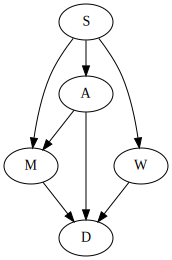

frozenset({frozenset({'M', 'S'}),
           frozenset({'A', 'M'}),
           frozenset({'S'}),
           frozenset({'A', 'S'}),
           frozenset({'A', 'M', 'S'})})

In [94]:
model = CausalGraphicalModel(
    nodes = ['W','S','M','A','D'],
    edges = [
             ['W','D'],
             ['S','W'], ['S','M'], ['S','A'],
             ['M','D'],   
             ['A','D'], ['A','M']  
            ],
)
display(model.draw())
model.get_all_backdoor_adjustment_sets('W', 'D')


#### Code 6.31

In [96]:
model.get_all_independence_relationships()

[('M', 'W', {'S'}),
 ('M', 'W', {'A', 'S'}),
 ('S', 'D', {'A', 'M', 'W'}),
 ('A', 'W', {'S'}),
 ('A', 'W', {'M', 'S'})]

#### Extra files for upcoming Chapter

In [101]:
traces = [trace_m6_6, trace_m6_7, trace_m6_8]

with m6_6:
    trace_m6_6 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})

with m6_7:
    trace_m6_7 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})

with m6_8:
    trace_m6_8 = pm.sample(cores = 1, progressbar=False, idata_kwargs={'log_likelihood': True})

# Save each trace as a NetCDF file for later loading
trace_m6_6.to_netcdf('data/model_traces/trace_m6_6.nc')
trace_m6_7.to_netcdf('data/model_traces/trace_m6_7.nc')
trace_m6_8.to_netcdf('data/model_traces/trace_m6_8.nc')


Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, p]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bt, bf]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a, bt]
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


'data/model_traces/trace_m6_8.nc'